# Subtracting the background from the thermal neutron peak.

This notebook will develop the method to subtract a background from the thermal neutron peak.
I'm not sure how many fast neutron counts (relative to thermals) we actually get, so this could be easy or medium difficulty.

In [1]:
import tables, json, time, peakutils
from scipy import stats
from scipy.signal import medfilt, wiener
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import mpl_scatter_density
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def getQ(wfm, fast=150, mfilt=True, wfilt=False):
    '''
    Return the charge in the waveform.
    If 'fast' is given it must be an integer.
    '''
    if mfilt:
        wfm = medfilt(wfm, kernel_size=7)
    if wfilt:
        wfm = wiener(wfm)
    BG = np.mean(wfm[10:30])
    Qt = sum(wfm[40:]) - (1024-40)*BG
    if not fast is None:
        Qf = sum(wfm[40:fast]) - (fast-40)*BG
    else:
        Qf = 0
    return Qt, Qf



Now to select which dataset(s) to use as test cases. Looking at preliminary estimate of Nthermals:

<img src="files/Ntherm_ALL.png" style="width:50%">

It seems that the 1.4 MeV neutrons have the biggest change in Ntherm, the 2.7 MeV neutrons have the biggest proportion at 0 moderator (so potentially the biggest interference), and the 6.7 MeV neutrons have the smallest change between 0 moderator and 4" moderator (so maybe the biggest effect from background). Let's have a look at each of these in turn, with the conventional PSD analysis.

In [3]:
with open("RunIndex.json", 'r') as fh:
    RunIdx = json.loads(fh.readline())
    
sabrepath = '/data/SABRE/ANU-20170512/'
flist = sorted(RunIdx.keys())

In [4]:
#Which file should we use?
fnames_1p4MeV = []
fnames_2p7MeV = []
fnames_6p7MeV = []
for key, item in RunIdx.items():
    if item['BeamEnergy_MeV']==3.5 and item['DetectorAngle_deg']==67.5:
        fnames_1p4MeV += [key]
    if item['BeamEnergy_MeV']==5 and item['DetectorAngle_deg']==67.5:
        fnames_2p7MeV += [key]
    if item['BeamEnergy_MeV']==12 and item['DetectorAngle_deg']==112.5:
        fnames_6p7MeV += [key]
        print(item['Comments'])


12 MeV protons, 135 deg, 0.25 nA pulsed, 1" moderator
12 MeV protons, 135 deg, 0.3 nA DC, 4" moderator
12 MeV protons, 135 deg, 0.25 nA pulsed, 2in moderator
12 MeV protons, 135 deg, <1nA variable DC, 4" moderator
12 MeV protons, 135 deg, 0.25 nA pulsed, no moderator
12 MeV protons, 135 deg, 0.25 nA pulsed, 4 in moderator


Note that there are 3 different 4" moderator runs for the backwards angle 12 MeV protons; the $<1$ nA variable run was crappy focussing, the 0.25 nA pulsed one was OK pulsed data, and the 0.3 nA DC run was after changing to DC.

Let's look at the 1.4 MeV data first...

In [5]:
Qts_1p4MeV = []
Qfs_1p4MeV = []
for i, fname in enumerate(fnames_1p4MeV):
    print("Processing file: {0}".format(fname))
    Nwfms = RunIdx[fname]['Nwfms']
    Qts_1p4MeV += [np.empty(Nwfms, dtype=np.float64)]
    Qfs_1p4MeV += [np.empty(Nwfms, dtype=np.float64)]
    h5file = tables.open_file(sabrepath+fname, 'r')
    for j in range(Nwfms):
        Qts_1p4MeV[i][j], Qfs_1p4MeV[i][j] = getQ(h5file.root.wfms[j,0])
    h5file.close()


Processing file: run1494676471.h5
Processing file: run1494681077.h5
Processing file: run1494678737.h5
Processing file: run1494674113.h5


In [6]:
#Make some functions to calculate the PSD FOM
def DoubleGauss(x, u0, u1, s0, s1, a0, a1):
    '''
    Compute a double Gaussian.
    '''
    return stats.norm.pdf(x, loc=u0, scale=s0)*a0 + \
        stats.norm.pdf(x, loc=u1, scale=s1)*a1

def GetFOM(Qt, Qf, x0=[0.2, 0.35, 0.01, 0.01, 3, 5], \
           Qtcut=[29000, 35000], hbins=1000, hrange=(0.,1.)):
    '''
    Make a PSD histogram and compute the FOM.
    Returns the FOM, fit parameters, and covariance matrix.
    '''
    thehist, edges = np.histogram((Qf/Qt)[(Qtcut[0]<-Qt)&(-Qt<Qtcut[1])],
                                    bins=hbins, range=hrange)
    centres = edges[:-1] + (edges[1]-edges[0])/2
    sigma = np.sqrt(thehist)
    #Make an educated guess about the peak parameters.
    pkguess = peakutils.peak.indexes(thehist, 0.35, 10)
    if len(pkguess)>1:
        x0[0] = centres[pkguess[0]]
        x0[1] = centres[pkguess[-1]]
    try:
        estimate, covmat = curve_fit(DoubleGauss, centres,
                                     thehist, x0)
    except RuntimeError:
        #Optimal parameters couldn't be found.
        return -1, -1, -1
    if not np.iterable(covmat):
        print("Something went wrong with the fit. Bailing...")
        return -1, estimate, covmat
    FOM = np.abs(estimate[0]-estimate[1])/(estimate[2]+estimate[3])
    return FOM, estimate, covmat


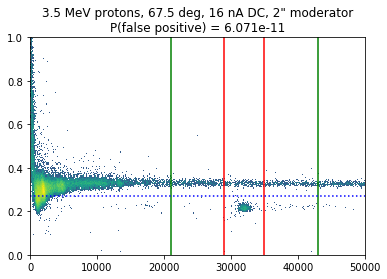

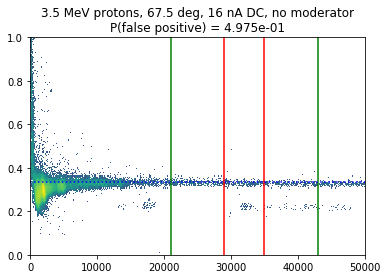

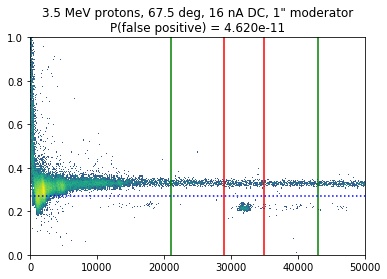

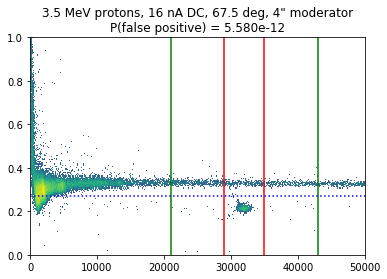

In [7]:
#Let's plot all of these to get an idea of where to make charge cuts:
FOMs = []
PSDcuts = []
Pfalsepositive = []
for i, (Qf, Qt) in enumerate(zip(Qfs_1p4MeV, Qts_1p4MeV)):
    plt.figure()
    ret = plt.hist2d(-Qt[(Qf/Qt)<=1], (Qf/Qt)[(Qf/Qt)<=1], bins=(1000,200), 
               range=((0, 50000), (0,1)), norm=LogNorm())
    plt.clim(0.1, np.max(ret[0]))
    thermregion = (29000,35000)
    extralength = 8000
    extraregion = (thermregion[0]-extralength, thermregion[1] + extralength)
    plt.vlines(thermregion, 0, 1, 'r')
    plt.vlines(extraregion, 0, 1, 'g')
    theFOM, theestimate, thecovmat = GetFOM(Qt, Qf)
    FOMs += [theFOM]
    neutidx = np.argmin(theestimate[0:2])
    PSDcuts += [theestimate[neutidx] + theFOM*theestimate[neutidx+2]]
    Pfalsepositive += [1 - 0.5*(1 + np.math.erf(theFOM/np.sqrt(2)))]
    plt.hlines(PSDcuts[i], 0, 50000, 'b', linestyles=':')
    plt.title('{0}\nP(false positive) = {1:.3e}'.format(RunIdx[fnames_1p4MeV[i]]['Comments'], Pfalsepositive[i]))
    plt.ylim(0.,1)


- The thermal range seems to span about 29000:35000, and a region about that can be used to estimate the fast neutron background: say +/- 8000? The limit here is avoiding the peak in fast neutrons at <20000. This might move for the other neutron energies, so I should be careful here... Either way the thermal range is ok.

- The PSD cut is set by the FOM in the thermal region: the fit for the 0 moderator case is not good; but that's hardly surprising.

- The false positive probabilities are surprisingly low, but (I guess) the peaks have some non-Gaussian tails that aren't fit properly.

Let's make histograms of the neutron events (below the PSD cut):

In [8]:
RunIdx[fnames_1p4MeV[0]].keys()

dict_keys(['HDPEThickness_mm', 'Nwfms', 'Comments', 'Source', 'Location', 'KnownBad', 'Pulsed', 'BeamEnergy_MeV', 'IsBeam', 'IsBG', 'BeamCurrent_nA', 'DAQParams', 'DetectorAngle_deg', 'IsSrc'])

BG = 2.106197028618039
Sum = 1612.0, BG-subtracted sum = 1485.6281782829176
BG = 0.6426780383902152
Sum = 143.0, BG-subtracted sum = 104.4393176965871
BG = 1.4184051778725064
Sum = 921.0, BG-subtracted sum = 835.8956893276496
BG = 2.6039327484956187
Sum = 2154.0, BG-subtracted sum = 1997.764035090263


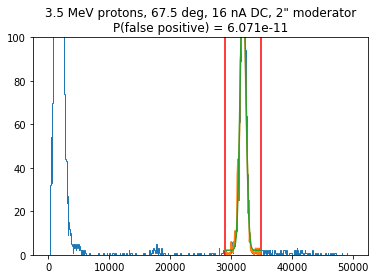

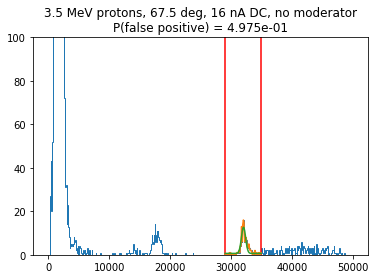

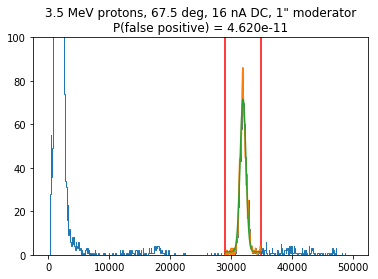

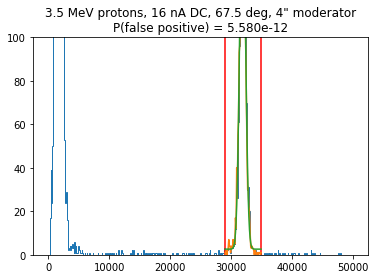

In [9]:
Nth_1p4MeV = np.empty(len(Qfs_1p4MeV), dtype=np.float64)
Nth_1p4MeV_gross = np.empty(len(Qfs_1p4MeV), dtype=np.float64)
thickness_1p4MeV = np.empty(len(Qfs_1p4MeV), dtype=np.float64)
for i, (Qf, Qt) in enumerate(zip(Qfs_1p4MeV, Qts_1p4MeV)):
    plt.figure()
    if FOMs[i] > 1:
        thehist, edges, otherstuff = plt.hist(-Qt[(Qf/Qt)<=PSDcuts[i]], bins=500, 
                         range=(0, 50000), histtype='step')
    else:
        avgPSDcut = np.mean(np.array(PSDcuts)[np.array(FOMs)>1])
        thehist, edges, otherstuff = plt.hist(-Qt[(Qf/Qt)<=avgPSDcut], bins=500, 
                        range=(0, 50000), histtype='step')

    plt.vlines(thermregion, 0, 1e3, 'r')
    plt.title('{0}\nP(false positive) = {1:.3e}'.format(RunIdx[fnames_1p4MeV[i]]['Comments'], Pfalsepositive[i]))
    #plt.yscale('log')
    plt.ylim(0,100)
    
    #Fit the thermal region:
    Gauss_wBG = lambda x, u0, s0, a0, BG: stats.norm.pdf(x, loc=u0, scale=s0)*a0 + BG
    thecentres = (edges[:-1] + (edges[1]-edges[0])/2)
    thehist = thehist[(thecentres>=thermregion[0])&(thecentres<=thermregion[1])]
    thecentres = thecentres[(thecentres>=thermregion[0])&(thecentres<=thermregion[1])]
    x0 = [np.median(thecentres), 500, max(thehist)*10, 1]
    theparams, thecov = curve_fit(Gauss_wBG, thecentres, thehist, x0)
    plt.plot(thecentres, thehist)
    plt.plot(thecentres, Gauss_wBG(thecentres, theparams[0], theparams[1], theparams[2], theparams[3]))
    print("BG = {0}".format(theparams[3]))
    print("Sum = {0}, BG-subtracted sum = {1}".format(sum(thehist), sum(thehist) - theparams[3]*len(thehist)))
    Nth_1p4MeV[i] = sum(thehist) - theparams[3]*len(thehist)
    Nth_1p4MeV_gross[i] = sum(thehist)
    thickness_1p4MeV[i] = RunIdx[fnames_1p4MeV[i]]['HDPEThickness_mm']
    

In [10]:
with open('/home/ljb103/NeutronSpec/Beamtime_CLYC_May2017/ThermAnalysis.json', 'r') as fh:
    ThermAnalysis_old = json.loads(fh.read())

In [11]:
EnMask_1p4 = []
EnMask_2p7 = []
EnMask_6p7 = []
for key, item in ThermAnalysis_old.items():
    if 'neutron energy' in key:
        for i, En in enumerate(item):
            if En == 1.4:
                EnMask_1p4 += [True]
            else:
                EnMask_1p4 += [False]
        for i, En in enumerate(item):
            if En == 2.7:
                EnMask_2p7 += [True]
            else:
                EnMask_2p7 += [False]
        for i, En in enumerate(item):
            if En == 6.7:
                EnMask_6p7 += [True]
            else:
                EnMask_6p7 += [False]

EnMask_1p4 = np.array(EnMask_1p4)
EnMask_2p7 = np.array(EnMask_2p7)
EnMask_6p7 = np.array(EnMask_6p7)

In [12]:
ThermAnalysis_old.keys()

dict_keys(['Uthermals', 'neutron energy (MeV)', 'Moderator Thickness (")', '# thermals'])

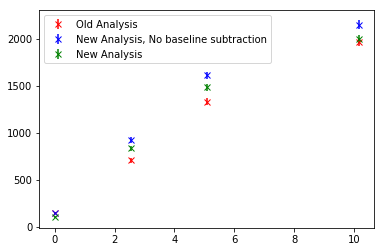

In [13]:
fig = plt.figure()
plt.errorbar(np.array(ThermAnalysis_old['Moderator Thickness (")'])[EnMask_1p4]*2.54,
             np.array(ThermAnalysis_old['# thermals'])[EnMask_1p4], 
             yerr=np.sqrt(np.array(ThermAnalysis_old['# thermals'])[EnMask_1p4]),
             fmt='rx', label='Old Analysis')
plt.errorbar(thickness_1p4MeV, Nth_1p4MeV_gross, yerr=np.sqrt(Nth_1p4MeV_gross), fmt='bx', 
             label='New Analysis, No baseline subtraction')
plt.errorbar(thickness_1p4MeV, Nth_1p4MeV, yerr=np.sqrt(Nth_1p4MeV), fmt='gx', 
             label='New Analysis')
plt.legend()

In [14]:
fig = plt.figure()
Qf = Qfs_1p4MeV[0]
Qt = Qts_1p4MeV[0]
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
mynorm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())
ax.scatter_density(-Qf[((Qf/Qt)>0) & ((Qf/Qt)<=1)], (Qf/Qt)[((Qf/Qt)>0) & ((Qf/Qt)<=1)], norm=LogNorm(vmin=0))
ax.set_xlim(0, 30000)
ax.set_ylim(0, 0.5)
#fig.savefig('gaussian.png')

(0, 0.5)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb01ffddd08> (for post_execute):


ValueError: values must all be positive

ValueError: values must all be positive

Actually, the plot above isn't any good, because it doesn't normalise to # acquisitions!
The previous analysis is normalised to per 100K acquisitions.

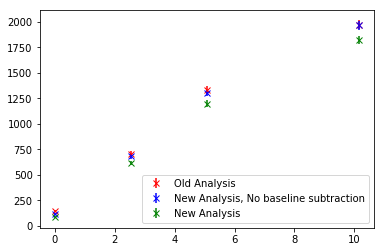

In [20]:
fig = plt.figure()
plt.errorbar(np.array(ThermAnalysis_old['Moderator Thickness (")'])[EnMask_1p4]*2.54,
             np.array(ThermAnalysis_old['# thermals'])[EnMask_1p4], 
             yerr=np.sqrt(np.array(ThermAnalysis_old['# thermals'])[EnMask_1p4]),
             fmt='rx', label='Old Analysis')
Datasizes = np.array([len(theQf) for theQf in Qfs_1p4MeV])
plt.errorbar(thickness_1p4MeV, (Nth_1p4MeV_gross/Datasizes)*1e5, yerr=(np.sqrt(Nth_1p4MeV_gross)/Datasizes)*1e5,fmt='bx', 
             label='New Analysis, No baseline subtraction')
plt.errorbar(thickness_1p4MeV, (Nth_1p4MeV/Datasizes)*1e5, yerr=(np.sqrt(Nth_1p4MeV)/Datasizes)*1e5, fmt='gx', 
             label='New Analysis')
plt.legend()

In [21]:
thickness_1p4MeV

array([  5.08,   0.  ,   2.54,  10.16])

In [19]:
np.array([len(theQf) for theQf in Qfs_1p4MeV])

array([123920, 119202, 135258, 109614])

In [25]:
sorted((Nth_1p4MeV/Datasizes)*1e5)

[87.615407205069616,
 618.00092366266665,
 1198.8606990662665,
 1822.5445974877873]

In [26]:
sorted(Nth_1p4MeV)

[104.4393176965871, 835.89568932764962, 1485.6281782829176, 1997.764035090263]